In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

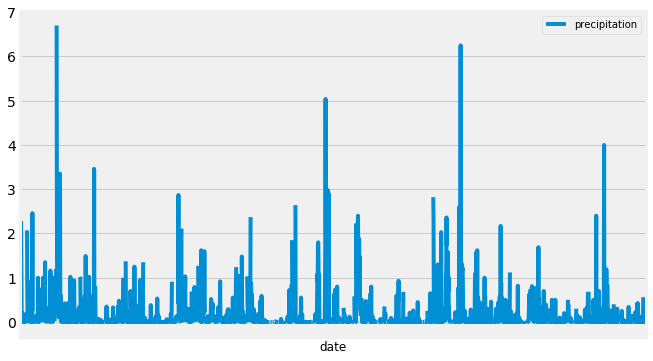

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last = dt.date.fromisoformat(session.query(Measurement.date).\
                             order_by(Measurement.date.desc()).\
                             first()._asdict()['date']) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > last).\
                    order_by(Measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(results, columns=['date', 'precipitation'])
prcp_df.set_index('date', inplace=True)

# Sort the dataframe by date
prcp_df.sort_values('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(figsize=(10, 6), xticks=[], fontsize=14)
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).distinct().count()

9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

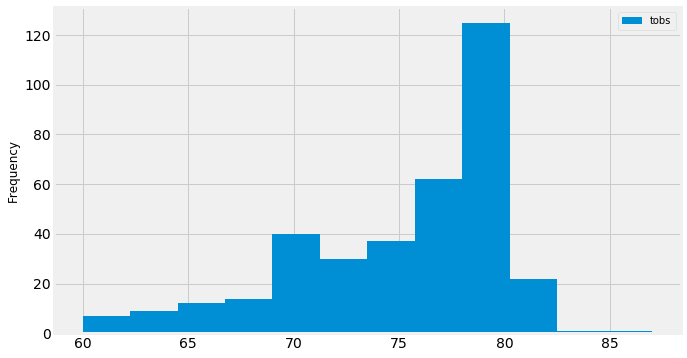

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active = session.query(Measurement.station).group_by(Measurement.station).\
                    filter(Measurement.date > last).order_by(func.count(Measurement.tobs).desc()).\
                    first()._asdict()['station']
active_results = session.query(Measurement.tobs).filter(Measurement.date > last, Measurement.station == active).all()

tobs_df = pd.DataFrame(active_results, columns=['tobs'])
tobs_df.plot.hist(bins=12, figsize=(10, 6), fontsize=14)
plt.show()

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
mystart = '2017-07-24'
myend = '2017-08-05'
res = calc_temps(mystart, myend)
tmin = res[0][0]
tavg = round(res[0][1], 2)
tmax = res[0][2]
print(f"tmin: {tmin}  |  tavg: {tavg}  |  tmax: {tmax}")

tmin: 72.0  |  tavg: 78.83  |  tmax: 84.0


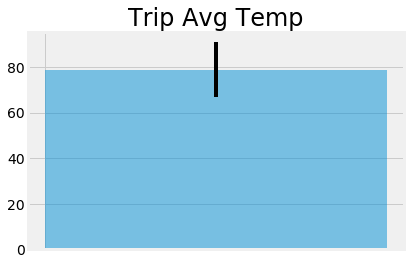

tmin: 72.0  |  tavg: 78.83  |  tmax: 84.0


In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.bar(0, tavg, yerr=(tmax-tmin), tick_label="", width = 0.4, alpha=0.5, align='edge')
plt.title('Trip Avg Temp', fontsize=24)
plt.yticks(fontsize=14)
plt.show()
print(f"tmin: {tmin}  |  tavg: {tavg}  |  tmax: {tmax}")

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the
# previous year's matching dates. Sort this in descending order by precipitation amount and
# list the station, name, latitude, longitude, and elevation
sel = [func.sum(Measurement.prcp),
       Station.station,
       Station.name,
       Station.latitude,
       Station.longitude,
       Station.elevation]

prcp_res = session.query(*sel).filter(Measurement.station == Station.station, Measurement.date >= mystart,\
                           Measurement.date <= myend).group_by(Measurement.station).\
                            order_by(func.sum(Measurement.prcp).desc()).all()

print("{:6s} {:12s} {:40s} {:8s} {:10s} {:>6s}".format("Prcp:", "Station:", "Name:", "Lat:", "Lng:", "Elev:"))
for s in prcp_res:
    print("{:<6.2f} {:12s} {:40s} {:<8.4f} {:<10.4f} {:>6.2f}".format(s[0], s[1], s[2], s[3], s[4], s[5]))

Prcp:  Station:     Name:                                    Lat:     Lng:        Elev:
2.75   USC00516128  MANOA LYON ARBO 785.2, HI US             21.3331  -157.8025  152.40
1.71   USC00514830  KUALOA RANCH HEADQUARTERS 886.9, HI US   21.5213  -157.8374    7.00
1.23   USC00519281  WAIHEE 837.5, HI US                      21.4517  -157.8489   32.90
0.86   USC00513117  KANEOHE 838.1, HI US                     21.4234  -157.8015   14.60
0.09   USC00519397  WAIKIKI 717.2, HI US                     21.2716  -157.8168    3.00
0.05   USC00519523  WAIMANALO EXPERIMENTAL FARM, HI US       21.3356  -157.7114   19.50
0.01   USC00517948  PEARL CITY, HI US                        21.3934  -157.9751   11.90


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.max(Measurement.date), func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).first()
    
daily_normals("01-01")

('2017-01-01', 62.0, 69.15384615384616, 77.0)

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = dt.date.fromisoformat(mystart)
end_date = dt.date.fromisoformat(myend)

# Use the start and end date to create a range of dates
date = start_date
dates = []
while date <= end_date:
    # Stip off the year and save a list of %m-%d strings
    dates.append(date.strftime("%m-%d"))
    date += dt.timedelta(days=1)

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [daily_normals(i) for i in dates]
normals

[('2017-07-24', 69.0, 76.55555555555556, 81.0),
 ('2017-07-25', 67.0, 76.89090909090909, 84.0),
 ('2017-07-26', 71.0, 76.4423076923077, 86.0),
 ('2017-07-27', 68.0, 76.58181818181818, 83.0),
 ('2017-07-28', 69.0, 76.46428571428571, 82.0),
 ('2017-07-29', 69.0, 76.47058823529412, 83.0),
 ('2017-07-30', 69.0, 77.35185185185185, 84.0),
 ('2017-07-31', 72.0, 77.03571428571429, 83.0),
 ('2017-08-01', 67.0, 75.54, 83.0),
 ('2017-08-02', 68.0, 75.60377358490567, 84.0),
 ('2017-08-03', 70.0, 76.61111111111111, 85.0),
 ('2017-08-04', 69.0, 76.71153846153847, 84.0),
 ('2017-08-05', 69.0, 76.14814814814815, 82.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normal_df = pd.DataFrame(normals, columns=['date', 'tmin', 'tavg', 'tmax'])
normal_df.set_index('date', inplace=True)
normal_df.head()

,tmin,tavg,tmax
date,,,
2017-07-24,69.0,76.555556,81.0
2017-07-25,67.0,76.890909,84.0
2017-07-26,71.0,76.442308,86.0
2017-07-27,68.0,76.581818,83.0
2017-07-28,69.0,76.464286,82.0


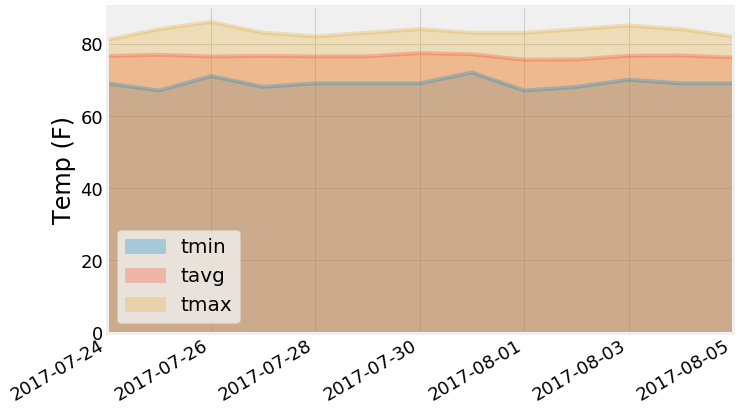

In [23]:
normal_df.plot.area(rot=30, stacked=False, alpha=.3, figsize=(10, 6), fontsize=18)
plt.legend(prop={'size': 20})
plt.xlabel('')
plt.xticks(ha='right')
plt.ylabel('Temp (F)', fontsize=24)
plt.show()